In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import nltk, string
from re import sub
from decimal import Decimal
from collections import defaultdict
from statistics import median
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

Cargamos todas las librerías que utilizaremos para analizar la información de la base de datos
y que permitirán ayudarnos en la predicción de nuestro modelo.

In [2]:
airbnb = pd.read_csv('./airbnb_data.csv')
airbnb.head()

,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,...,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,price
0,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,...,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0,169.0
1,Apartment,Private room,"{TV,""Wireless Internet"",Heating,""Smoke detecto...",2,1.0,Real Bed,strict,True,SF,Beautiful private room overlooking scenic view...,...,-122.429526,Comfort Suite San Francisco,Noe Valley,3,100.0,https://a0.muscache.com/im/pictures/82509143-4...,94131,1.0,1.0,85.0
2,Condominium,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Wheelchair...",2,1.0,Real Bed,moderate,True,LA,Arguably the best location (and safest) in dow...,...,-118.260439,"Near LA Live, Staple's. Starbucks inside. OWN ...",Downtown,9,93.0,https://a0.muscache.com/im/pictures/61bd05d5-c...,90015,1.0,1.0,120.0
3,House,Private room,"{TV,""Cable TV"",""Wireless Internet"",""Pets live ...",2,1.0,Real Bed,moderate,True,SF,Garden Studio with private entrance from the s...,...,-122.501095,Cozy Garden Studio - Private Entry,Richmond District,159,99.0,https://a0.muscache.com/im/pictures/0ed6c128-7...,94121,1.0,1.0,120.0
4,Apartment,Private room,"{Internet,""Wireless Internet"",""Air conditionin...",2,1.0,Real Bed,strict,True,NYC,This is a bright bedroom in an historic buildi...,...,-73.983880,Large East Village Bedroom To Let!,Alphabet City,82,93.0,https://a0.muscache.com/im/pictures/21726900/1...,10009.0,1.0,1.0,100.0


Analizamos el tipo de información que tenemos en la base de datos. Encontramos que no existen valores nulos y que tenemos 3 tipos de datos como son **object** **float** y **bool**

In [3]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28877 entries, 0 to 28876
Data columns (total 28 columns):
property_type             28877 non-null object
room_type                 28877 non-null object
amenities                 28877 non-null object
accommodates              28877 non-null int64
bathrooms                 28877 non-null float64
bed_type                  28877 non-null object
cancellation_policy       28877 non-null object
cleaning_fee              28877 non-null bool
city                      28877 non-null object
description               28877 non-null object
first_review              28877 non-null object
host_has_profile_pic      28877 non-null object
host_identity_verified    28877 non-null object
host_response_rate        28877 non-null object
host_since                28877 non-null object
instant_bookable          28877 non-null object
last_review               28877 non-null object
latitude                  28877 non-null float64
longitude                 28

In [4]:
airbnb.isnull().sum()

property_type             0
room_type                 0
amenities                 0
accommodates              0
bathrooms                 0
bed_type                  0
cancellation_policy       0
cleaning_fee              0
city                      0
description               0
first_review              0
host_has_profile_pic      0
host_identity_verified    0
host_response_rate        0
host_since                0
instant_bookable          0
last_review               0
latitude                  0
longitude                 0
name                      0
neighbourhood             0
number_of_reviews         0
review_scores_rating      0
thumbnail_url             0
zipcode                   0
bedrooms                  0
beds                      0
price                     0
dtype: int64

Analizando la base de datos, nos damos cuenta que **description', 'name', 'thumbnail_url','neighbourhood', 'zipcode'** son las variables que tiene un bajo nivel explicativo para determinar el precio de un AirBnb. Finalmente, nos quedamos con 23 columnas
y 28,877 registros por fila.

In [5]:
airbnb = airbnb.drop(columns=['description', 'name', 'thumbnail_url','neighbourhood', 'zipcode'])

In [6]:
airbnb.shape

(28877, 23)

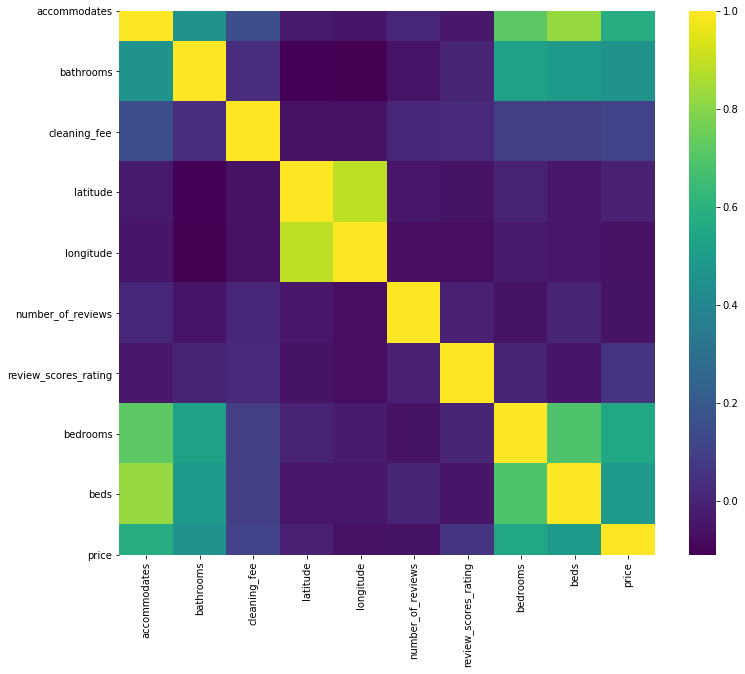

In [7]:
plt.figure(figsize=(12,10))
sns.heatmap(airbnb.corr(), cmap='viridis');

Algunos **insights** de la base de datos con base en los datos numéricos del DF.

In [8]:
dataPriceList = []
for index, row in airbnb.iterrows():
    dataPriceList.append(float(row['price']))
print("Min:", min(dataPriceList))
print("Max:", max(dataPriceList))
print("Mean:", np.mean(dataPriceList))
print("Median:", median(dataPriceList))
print("STD:", np.std(dataPriceList))

Min: 1.0
Max: 1995.0000000000007
Mean: 146.2619039373896
Median: 110.00000000000004
STD: 131.592001403111


In [9]:
airbnb['city'].value_counts()

NYC        13379
LA          7571
SF          2713
DC          1815
Boston      1776
Chicago     1623
Name: city, dtype: int64

In [10]:
airbnb['room_type'].value_counts()

Entire home/apt    16158
Private room       11993
Shared room          726
Name: room_type, dtype: int64

In [11]:
airbnb['property_type'].value_counts().head()

Apartment      18543
House           6655
Condominium     1081
Townhouse        720
Loft             552
Name: property_type, dtype: int64

In [12]:
airbnb['review_scores_rating'].value_counts(ascending=False).head()

100.0    7007
98.0     2512
97.0     2314
96.0     2286
95.0     2036
Name: review_scores_rating, dtype: int64

Transformaremos algunos tipos de datos de categóricas a numéricas mediante un dummy como son: **'cancellation_policy', 'cleaning_fee', 'host_has_profile_pic', 'host_identity_verified',
'instant_bookable'**

Transformaremos algunas variables a un tipo numérico como son: **'first_review', 'last_review', 'host_since'**.

In [13]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28877 entries, 0 to 28876
Data columns (total 23 columns):
property_type             28877 non-null object
room_type                 28877 non-null object
amenities                 28877 non-null object
accommodates              28877 non-null int64
bathrooms                 28877 non-null float64
bed_type                  28877 non-null object
cancellation_policy       28877 non-null object
cleaning_fee              28877 non-null bool
city                      28877 non-null object
first_review              28877 non-null object
host_has_profile_pic      28877 non-null object
host_identity_verified    28877 non-null object
host_response_rate        28877 non-null object
host_since                28877 non-null object
instant_bookable          28877 non-null object
last_review               28877 non-null object
latitude                  28877 non-null float64
longitude                 28877 non-null float64
number_of_reviews         2

In [14]:
from datetime import datetime
def conver_time(df):
    df=datetime.strptime(df, '%Y-%m-%d').date()
    return df.toordinal()

In [15]:
airbnb.first_review = airbnb.first_review.apply(conver_time)

In [16]:
airbnb.last_review = airbnb.last_review.apply(conver_time)

In [17]:
airbnb.host_since = airbnb.host_since.apply(conver_time)

In [18]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28877 entries, 0 to 28876
Data columns (total 23 columns):
property_type             28877 non-null object
room_type                 28877 non-null object
amenities                 28877 non-null object
accommodates              28877 non-null int64
bathrooms                 28877 non-null float64
bed_type                  28877 non-null object
cancellation_policy       28877 non-null object
cleaning_fee              28877 non-null bool
city                      28877 non-null object
first_review              28877 non-null int64
host_has_profile_pic      28877 non-null object
host_identity_verified    28877 non-null object
host_response_rate        28877 non-null object
host_since                28877 non-null int64
instant_bookable          28877 non-null object
last_review               28877 non-null int64
latitude                  28877 non-null float64
longitude                 28877 non-null float64
number_of_reviews         2887

In [19]:
airbnb.cleaning_fee = airbnb.cleaning_fee.astype(int)

In [20]:
airbnb.host_has_profile_pic = airbnb.host_has_profile_pic.astype(bool)

In [21]:
airbnb.host_identity_verified = airbnb.host_identity_verified.astype(bool)

In [22]:
airbnb.instant_bookable = airbnb.instant_bookable.astype(bool)

In [23]:
airbnb.cancellation_policy = airbnb.cancellation_policy.astype(bool)

In [24]:
airbnb.host_has_profile_pic = airbnb.host_has_profile_pic.astype(int)

In [25]:
airbnb.host_identity_verified = airbnb.host_identity_verified.astype(int)

In [26]:
airbnb.instant_bookable = airbnb.instant_bookable.astype(int)

In [27]:
airbnb.cancellation_policy = airbnb.cancellation_policy.astype(int)

In [28]:
airbnb.host_response_rate = airbnb.host_response_rate.astype(bool)

In [29]:
airbnb.host_response_rate = airbnb.host_response_rate.astype(int)

Ahora buscaremos recuperar las amenidades que se ofrecen en cada uno de los lugares para hospedarse y asignarlos como una columna nueva al DataFrame

In [30]:
airbnb['amenities'] = airbnb['amenities'].str.replace( '{','')
airbnb['amenities'] = airbnb['amenities'].str.replace( '}','')
airbnb['amenities'] = airbnb['amenities'].str.replace( '"','') 
airbnb['amenities'].head()

0    Wireless Internet,Air conditioning,Kitchen,Hea...
1    TV,Wireless Internet,Heating,Smoke detector,Ca...
2    TV,Cable TV,Wireless Internet,Wheelchair acces...
3    TV,Cable TV,Wireless Internet,Pets live on thi...
4    Internet,Wireless Internet,Air conditioning,Ki...
Name: amenities, dtype: object

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer =  CountVectorizer(tokenizer=lambda x: x.split(','))
amenities = count_vectorizer.fit_transform(airbnb['amenities'])
df_amenities = pd.DataFrame(amenities.toarray(), columns=count_vectorizer.get_feature_names())
df_amenities = df_amenities.drop('',1,inplace=False)

In [33]:
airbnb2 = pd.concat([airbnb, df_amenities], axis=1, join='inner')
airbnb2.shape

(28877, 152)

In [34]:
#def get_amenities(airbnb):
 #   amenityList = []
  #  for index, row in airbnb.iterrows():
   #     amenities = set(row['amenities'].replace('"', "").replace('{', "").replace('}', "").split(','))
    #    for amenity in amenities:
     #       if "translation missing" not in amenity and amenity != '':
      #          amenityList.append(amenity)
 #   return amenityList

In [35]:
#x = get_amenities(airbnb)

In [36]:
#airbnb['Amenities_List'] = pd.Series(x)

In [37]:
#def createOneHotVector(categories):
 #   categoryOneHotVector = dict()
  #  index = 0
  #  for category in categories:
   #     oneHotVector = []
   #     for i in range(len(categories)):
    #        oneHotVector.append(1 if i == index else 0)
   #     index += 1
    #    categoryOneHotVector[category] = oneHotVector
    
   # return categoryOneHotVector

In [38]:
#roomTypeOneHotVector = createOneHotVector(airbnb.room_type.unique())
#bedTypeOneHotVector = createOneHotVector(airbnb.bed_type.unique())

In [39]:
#airbnb['roomtype_vector'] = pd.Series(roomTypeOneHotVector)
#airbnb['bedtype_vector'] = pd.Series(bedTypeOneHotVector)

In [40]:
airbnb2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28877 entries, 0 to 28876
Columns: 152 entries, property_type to wireless internet
dtypes: float64(7), int64(140), object(5)
memory usage: 33.5+ MB


In [41]:
airbnb.head()

,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,first_review,...,host_since,instant_bookable,last_review,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds,price
0,Apartment,Entire home/apt,"Wireless Internet,Air conditioning,Kitchen,Hea...",7,1.0,Real Bed,1,1,NYC,736546,...,736499,1,736595,40.766115,-73.989040,6,93.0,3.0,3.0,169.0
1,Apartment,Private room,"TV,Wireless Internet,Heating,Smoke detector,Ca...",2,1.0,Real Bed,1,1,SF,736568,...,736487,1,736577,37.753164,-122.429526,3,100.0,1.0,1.0,85.0
2,Condominium,Entire home/apt,"TV,Cable TV,Wireless Internet,Wheelchair acces...",2,1.0,Real Bed,1,1,LA,736314,...,735006,1,736431,34.046737,-118.260439,9,93.0,1.0,1.0,120.0
3,House,Private room,"TV,Cable TV,Wireless Internet,Pets live on thi...",2,1.0,Real Bed,1,1,SF,736007,...,735753,1,736596,37.781128,-122.501095,159,99.0,1.0,1.0,120.0
4,Apartment,Private room,"Internet,Wireless Internet,Air conditioning,Ki...",2,1.0,Real Bed,1,1,NYC,734986,...,734954,1,736283,40.723883,-73.983880,82,93.0,1.0,1.0,100.0


Hacemos una copia del DataFrame únicamente con las **columnas numéricas** para entrenar nuestro modelo

In [42]:
airbnb_numeric = airbnb2._get_numeric_data().copy()

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X=airbnb_numeric.drop('price', axis=1)
y=airbnb_numeric.price

In [44]:
modelo=LinearRegression()

In [45]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2)

In [46]:
modelo.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [47]:
train_score=modelo.score(X_train, y_train)
test_score=modelo.score(X_test, y_test)
print (train_score, test_score)

0.4731292490016904 0.5051246365685065


In [48]:
from sklearn.ensemble import RandomForestRegressor as RFR

rf=RFR(n_estimators=16, min_samples_leaf=3)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=16,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [49]:
train_score=rf.score(X_train, y_train)
test_score=rf.score(X_test, y_test)
print (train_score, test_score)

0.8739371871190964 0.6917151380988674
